In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.optimize import curve_fit

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import field_map_config_run1 as map_config

from IPython.display import clear_output

pair_dict = map_config.pair_dict


Welcome to JupyROOT 6.22/02


In [ ]:
runs = map_config.runs

columns = [['st'+str(st)+',dt'] +  ['st'+str(st)+',m'+str(m+1) for m in range(9)] for st in range(72)]
columns = [item for sublist in columns for item in sublist]

sync_offset_df = pd.DataFrame(columns=columns)

for run in runs:
    for pair in pair_dict[run]:

        file_name = 'hdf5/2020-09-30_run_'+run+'.h5'
        keys = pair_dict[run][pair]

        tr_dfs = {}

        tr_dfs[keys[0]] = pd.read_hdf(file_name, key=keys[0])
        tr_dfs[keys[1]] = pd.read_hdf(file_name, key=keys[1])

        tr_dfs = helper.interp_to_moment(tr_dfs, keys=keys)
        tr_dfs = helper.moment_to_corrected(tr_dfs, keys=keys)

        tr_hybrid_dfs = helper.bloch_style_moments(tr_dfs, keys=keys)

        sync_offsets, delta_time = helper.sync_offset_calc(tr_dfs[keys[0]], tr_dfs[keys[1]])
        row = {}

        for st in range(72):
            for m in range(9):
                row['st'+str(st)+',m'+str(m+1)] = sync_offsets[st,m]
            row['st'+str(st)+',dt'] = delta_time[st]
        
        sync_offset_df = sync_offset_df.append(pd.DataFrame(row, index=['run_'+run+pair[6]]))

        clear_output()
        print 'Done with run '+run+pair[6]
        
sync_offset_df = sync_offset_df[columns]
sync_offset_df = sync_offset_df.sort_index()

In [ ]:
sync_offset_df.to_hdf('/data2/aetb/2020-09-30_hybrid_sync_offset_df.h5', key='sync_offset_df')

In [10]:
sync_offset_df = pd.read_hdf('/data2/aetb/2020-09-30_hybrid_sync_offset_df.h5', key='sync_offset_df')
sync_offset_df = sync_offset_df.iloc[0:-1]

In [61]:
# calculate rates

# assume a constant random walk rate across all stations and runs

rates = np.empty((792,9))
                 
for m in range(9):
    _ = np.array([])
    for st in range(72):
        _ = np.append(_, (sync_offset_df['st'+str(st)+',m'+str(m+1)]/sync_offset_df['st'+str(st)+',dt']**0.5).values)
    rates[:,m] = _

[4.56668293e-03 2.39702431e-04 2.23624253e-04 1.06138686e-04
 3.40662192e-04 3.02648014e-05 7.69850642e-05 4.63122653e-05
 9.34178986e-05]


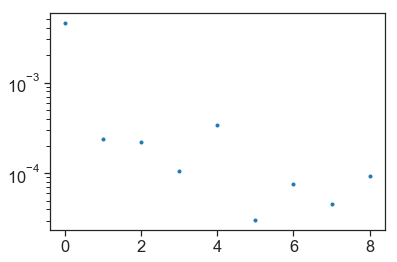

In [79]:
drift_rates = np.empty(9)

for m in range(9):
    counts, bins = np.histogram(rates[:,m], bins=50)
    bins = (bins[:-1]+bins[1:])/2
    p, cov = curve_fit(lambda x,A,s,x0: A*np.exp(-(x-x0)**2/s**2),  bins,  counts,  p0=(170, 0.1, 0))

    drift_rates[m] = p[1]**2

print drift_rates  ## in Hz^2/sec

plt.semilogy(drift_rates, '.')

[ 1.74434821e+02  6.75772368e-02 -2.63667341e-04]

[[ 2.14340815e+01 -5.53597720e-03 -4.89423107e-09]
 [-5.53597720e-03  4.28948272e-06  1.99798384e-12]
 [-4.89423107e-09  1.99798384e-12  2.14473638e-06]]
0.0045666829319112095
0.047018003710265786
0.005541124876897199


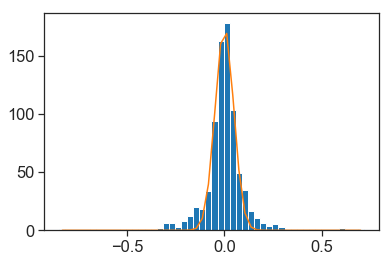

In [73]:
m = 0

counts, bins, _ = plt.hist(rates[:,m], bins=50)

bins = (bins[:-1]+bins[1:])/2

p, cov = curve_fit(lambda x,A,s,x0: A*np.exp(-(x-x0)**2/s**2),  bins,  counts,  p0=(170, 0.1, 0))
print p
print
print cov

plt.plot(bins, p[0]*np.exp(-(bins - p[2])**2/p[1]**2))

print p[1]**2
print np.std(rates[:,m]**2)

print np.std(rates[:,m]**2)/np.sqrt(72)

In [65]:
p, cov = curve_fit(lambda x,A,s,x0: A*np.exp(-(x-x0)**2/s**2),  bins,  counts,  p0=(170, 0.1, 0))
print p
print
print cov

[ 1.74434821e+02  6.75772368e-02 -2.63667341e-04]

[[ 2.14340815e+01 -5.53597720e-03 -4.89423107e-09]
 [-5.53597720e-03  4.28948272e-06  1.99798384e-12]
 [-4.89423107e-09  1.99798384e-12  2.14473638e-06]]


(0, 0.1)

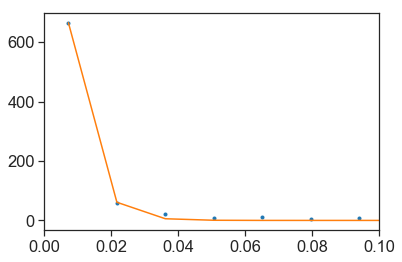

In [57]:
plt.plot(bins, counts, '.')
plt.plot(bins, p[0]*np.exp(p[1]*bins))
plt.xlim([0,0.1])

In [58]:
-1./p[1]

0.00606126059704329